In [1]:
import patchseq_utils.analysis as utils
from patchseq_utils import plotting as plot
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# fix slow autocomplete
%config Completer.use_jedi = False

pd.set_option('use_inf_as_na', True)
pd.options.display.max_columns=300
pd.options.display.max_rows=300
sns.set(style='ticks', context='talk')
from importlib import reload

In [2]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [3]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

In [9]:
def process_df(shiny, species='mouse'):
    shiny['target_layer'] = shiny.layer.fillna('').apply(get_num)
    shiny.drop(columns=['layer'], inplace=True)

    shiny['layer_ccf'] = shiny['structure'].fillna('').apply(get_num)
    shiny['cortical_area_ccf'] = shiny['structure'].fillna('').apply(not_num)
    shiny['has_morph'] = shiny.swc_path.notna()
    shiny['has_ephys'] = shiny.nwb_path.notna()

    if species=='mouse':
        shiny['tx_qc'] = shiny.apply(lambda df:
                                            (df.Tree_call!='PoorQ') &
                                            (df.rna_amp_pass_fail == "Pass")
                                           , axis=1)
        shiny[cluster] = shiny[cluster].astype(ttypes_mouse)
        shiny['homology_type'] = shiny[cluster].map(homology_mapping_mouse).astype(homology_types)
    else:
        shiny[cluster] = shiny[cluster].astype(ttypes_human)
        shiny['homology_type'] = shiny[cluster].map(homology_mapping_human).astype(homology_types)
    return shiny

shiny_df = get_shiny('mouse', nms_pass=False)

## AIBS TEa

In [10]:
# already filtered by layer_ccf - could refine for those with strict layer
shiny = pd.read_csv("~/projects/human_l1/mouse_l1_dataset_full_tea_2022_02_04.csv", index_col=0,
                          dtype = {'layer_ccf': str})
cluster = 't-type'
shiny[cluster] = shiny[cluster].astype(ttypes_mouse)
shiny['homology_type'] = shiny[cluster].map(homology_mapping_mouse).astype(homology_types)

In [11]:
aibs_all = shiny.join(mouse_ephys)
data = aibs_all.loc[lambda df: df[ephys_features].notna().sum(axis=1) > 0].copy()
data['cortical_area'] = data.structure.map(lambda x: x[:3])
data = data.loc[lambda df: df['cortical_area'].isin(['VIS', 'TEa'])]

In [12]:
data.cortical_area.value_counts()

VIS    321
TEa     17
Name: cortical_area, dtype: int64

** TODO: consider relaxing Tx QC for this analysis??

In [13]:
cells = data.query("cortical_area=='TEa'").index.difference(mouse_df.index)
shiny_df.loc[cells, ['contam_sum','Tree_call','Norm_Marker_Sum.0.4']]

,contam_sum,Tree_call,Norm_Marker_Sum.0.4
942857102,0.322878,PoorQ,TRUE
1144622913,0.441632,PoorQ,TRUE
1146326038,0.254932,Core,TRUE
1146361502,1.095738,PoorQ,TRUE
1147429279,0.559477,Core,TRUE


In [14]:
mouse_df['cortical_area'] = mouse_df.structure.map(lambda x: x[:3])
mouse_df.cortical_area.value_counts()

VIS    583
TEa     17
Name: cortical_area, dtype: int64

In [15]:
variable = 'cortical_area'
features = data.groupby(variable)[ephys_features].apply(
    lambda x: x.notna().mean(axis=0)).min().loc[lambda x: x>0.5].index


In [16]:
results = utils.run_twosamp(data, features, variable)
results.head(10)

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
width_suprathresh_short_square,0.008367,0.379645,0.689823,0.740514,0.082765,332,0.951643,0.468408
vm_for_sag,0.017146,0.364444,0.682222,0.111239,0.421683,330,0.620996,0.468408
rheobase_i,0.018427,0.360000,0.680000,0.019901,0.615085,330,0.524054,0.468408
peak_deltav_rheo,0.023717,0.345820,0.672910,0.057590,0.502335,330,0.620996,0.468408
peak_v_rheo,0.034677,0.322963,0.661481,0.078117,0.466246,330,0.620996,0.504221
width_short_square,0.050184,0.282056,0.641028,0.250987,0.286579,334,0.734369,0.504221
width_suprathresh_rheo,0.052135,0.296931,0.648466,0.043754,0.533267,330,0.620996,0.504221
trough_v_rheo,0.054733,0.293757,0.646878,0.084312,0.456888,330,0.620996,0.504221
peak_deltav_ramp,0.058783,0.272416,0.636208,0.117911,0.390286,326,0.620996,0.504221


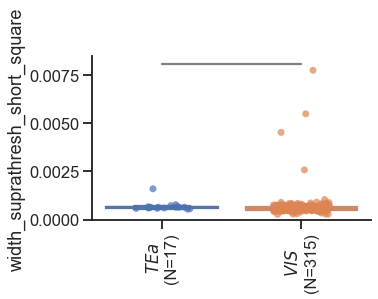

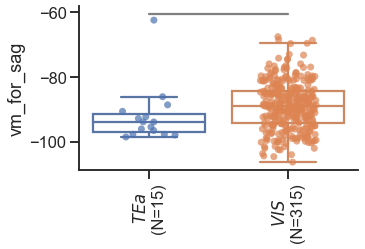

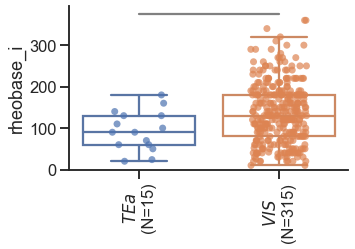

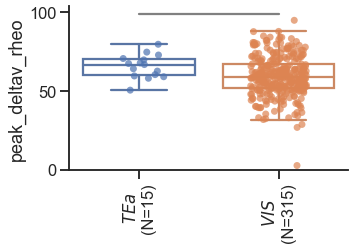

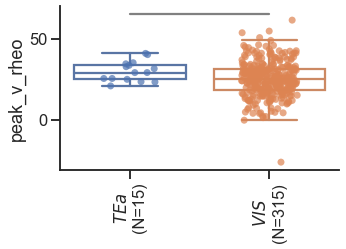

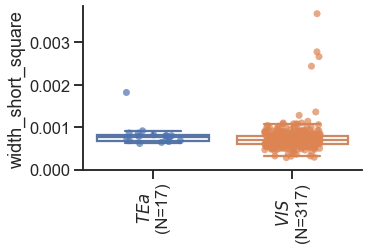

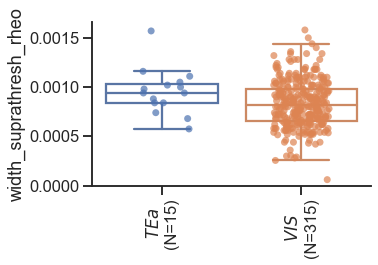

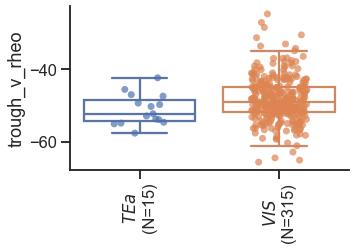

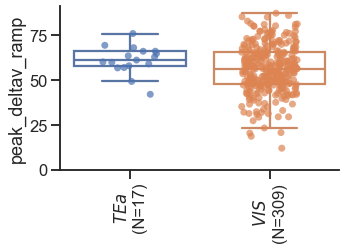

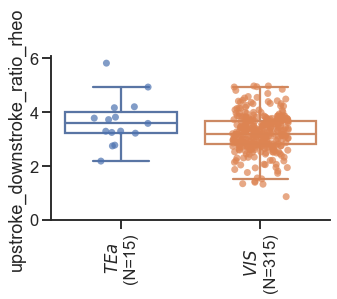

In [17]:
for y in results.index[:10]:
    fig, ax = plt.subplots(figsize=(5,3))
    utils.plot_box_cluster_feature(data, y, variable, pairs_sets=['all'], label_yaxis=True, size=7, ax=ax)

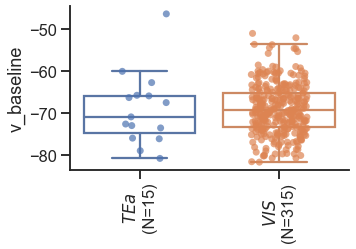

In [18]:
    fig, ax = plt.subplots(figsize=(5,3))
    utils.plot_box_cluster_feature(data, "v_baseline", variable, pairs_sets=['all'], label_yaxis=True, size=7, ax=ax)

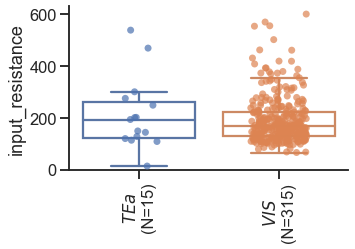

In [19]:
    fig, ax = plt.subplots(figsize=(5,3))
    utils.plot_box_cluster_feature(data, "input_resistance", variable, pairs_sets=['all'], label_yaxis=True, size=7, ax=ax)

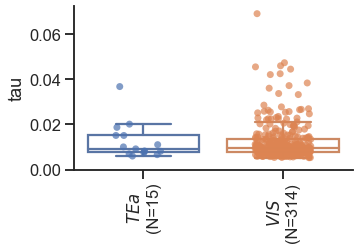

In [20]:
    fig, ax = plt.subplots(figsize=(5,3))
    utils.plot_box_cluster_feature(data, "tau", variable, pairs_sets=['all'], label_yaxis=True, size=7, ax=ax)

## Load mansvelder

In [21]:
shiny_tea = shiny_df.loc[lambda df: df['sample_id'].str.startswith('PH')
                 & df['roi'].str.startswith('TEaL1') & (df['broad_class']=='GABAergic')
            ]
shiny_tea.shape

# shiny_tea.to_csv("/home/tom.chartrand/projects/human_l1/l1_mouse_mansvelder_shiny.csv")

(47, 105)

In [22]:
mansvelder_df = pd.read_csv("/home/tom.chartrand/projects/data/u01/mansvelder_mouse/features_E.csv", index_col=0)

tea_df = shiny_tea.join(mansvelder_df, how='inner', on='cell_name')
tea_df.roi.value_counts(dropna=False)

TEaL1    28
Name: roi, dtype: int64

In [23]:
tea_df.structure_lims.value_counts(dropna=False)

NaN        19
TEa1        6
ECT1        1
AUDp1       1
AUDv2/3     1
Name: structure_lims, dtype: int64

In [24]:
tea_df = process_df(tea_df)
tea_df = tea_df.loc[lambda df: df.cortical_area_ccf.isna() | (df.cortical_area_ccf=='TEa')]
# drop older -70 mV holding: 10 cells
# tea_df = tea_df.loc[tea_df.patch_date.map(lambda x: x.split('-')[1]).astype(int) > 7]

In [25]:
tea_df.cortical_area_ccf.value_counts(dropna=False)

NaN    19
TEa     6
Name: cortical_area_ccf, dtype: int64

In [26]:
tea_df['tx_qc'].value_counts(dropna=False)

False    15
True     10
Name: tx_qc, dtype: int64

In [27]:
tea_df['Norm_Marker_Sum.0.4'].value_counts(dropna=False)

TRUE     15
FALSE    10
Name: Norm_Marker_Sum.0.4, dtype: int64

In [28]:
tea_df['rna_amp_pass_fail'].value_counts(dropna=False)

Pass    15
Fail    10
Name: rna_amp_pass_fail, dtype: int64

In [29]:
df = tea_df.loc[lambda df: df['Norm_Marker_Sum.0.4']=="TRUE"]
df['Tree_call'].value_counts(dropna=False)

Core     5
PoorQ    5
I1       4
I2       1
Name: Tree_call, dtype: int64

In [30]:
tea_df.homology_type.value_counts(dropna=False)

MC4R     9
LAMP5    8
NaN      7
PAX6     1
other    0
VIP      0
Name: homology_type, dtype: int64

In [31]:
tea_df.query('tx_qc').homology_type.value_counts(dropna=False)

LAMP5    5
MC4R     4
NaN      1
other    0
VIP      0
PAX6     0
Name: homology_type, dtype: int64

In [32]:
tea_df.loc[lambda df: df.tx_qc & df.homology_type.isna()].topLeaf.value_counts(dropna=False)

Sst Hpse Cbln4    1
Name: topLeaf, dtype: int64

In [33]:
tea_df.loc[lambda df: ~df.tx_qc & df.homology_type.isna()].topLeaf.value_counts(dropna=False)

Pvalb Th Sst          1
Vip Igfbp4 Mab21l1    1
Vip Lmo1 Fam159b      1
Vip Igfbp6 Car10      1
Sst Tac1 Tacr3        1
Lamp5 Lhx6            1
Name: topLeaf, dtype: int64

## Feature significance comparisons

In [34]:
combined = pd.concat([data.loc[ lambda df: df['cortical_area']=='VIS'],
                      human_df.loc[ lambda df: df['layer_lims']=='1']],
                    sort=False)

In [35]:
variable = 'cortical_area'
features = data.groupby(variable)[ephys_features].apply(
    lambda x: x.notna().mean(axis=0)).min().loc[lambda x: x>0.5].index
metric='mw_r'
pval='pval_mw_fdr'
labels = {x: feature_name(x) for x in features}

Text(0.5, 0, 'r')

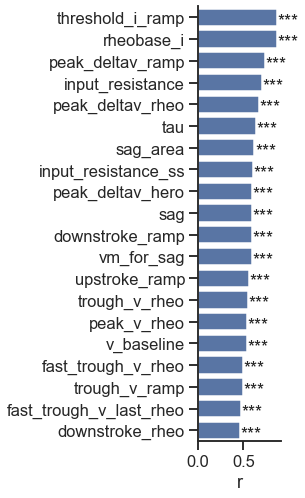

In [36]:
results = utils.run_twosamp(combined, features, 'species').sort_values(metric, ascending=False)
utils.plot_feature_effect_sizes(results, pval=pval, val=metric)
plt.xlabel('r')
# plt.title('Cohens D')

In [37]:
corr = pd.concat([human_ephys, mouse_ephys])[ephys_features].corr()
df = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack()
df.loc[lambda x: np.abs(x)>0.8]

upstroke_downstroke_ratio_ramp  upstroke_downstroke_ratio_rheo    0.840225
                                upstroke_downstroke_ratio_hero    0.806182
threshold_v_ramp                threshold_v_rheo                  0.839170
                                threshold_v_hero                  0.822622
width_ramp                      width_suprathresh_ramp            0.994668
upstroke_ramp                   peak_deltav_ramp                  0.856213
                                upstroke_rheo                     0.847027
                                upstroke_hero                     0.830243
downstroke_ramp                 downstroke_rheo                   0.893070
                                downstroke_hero                   0.872850
trough_v_ramp                   trough_v_rheo                     0.863707
                                fast_trough_v_rheo                0.839182
                                fast_trough_v_last_rheo           0.850047
                         

In [38]:
def select_distinct(ranked, corr, nfeat=10, threshold=0.8):
    distinct_features = []
    for x in ranked:
        if len(distinct_features)==nfeat:
            return distinct_features
        for y in distinct_features:
            if np.abs(corr.loc[x,y]) > threshold:
                break
        else:
            distinct_features.append(x)
    return distinct_features

Text(0.5, 0, 'r')

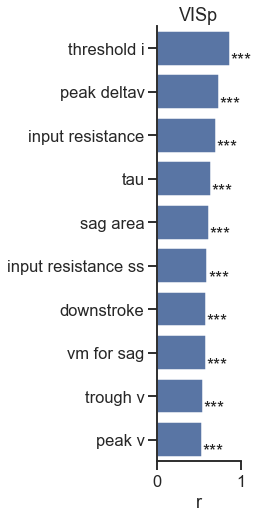

In [39]:
top_feat = select_distinct(results.index, corr, threshold=0.8)
utils.plot_feature_effect_sizes(results.loc[top_feat], ylabels=labels, pval=pval, val=metric)
plt.title('VISp')
plt.xlim(0, 1)
plt.xlabel('r')

Text(0.5, 0, 'r')

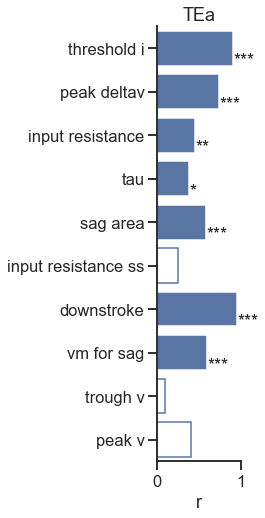

In [40]:
combined_tea = pd.concat([
    tea_df.loc[lambda df: df['Norm_Marker_Sum.0.4']=='TRUE'],
    data.loc[ lambda df: df['cortical_area']=='TEa'],
  human_df.loc[ lambda df: df['layer_lims']=='1'],
                         ],
                    sort=False)


results_tea = utils.run_twosamp(combined_tea, features, 'species')
utils.plot_feature_effect_sizes(results_tea.loc[top_feat], ylabels=labels, pval=pval,
                                val=metric, sort=False)
plt.title('TEa')
plt.xlim(0, 1)
plt.xlabel('r')

Text(0.5, 0, 'r')

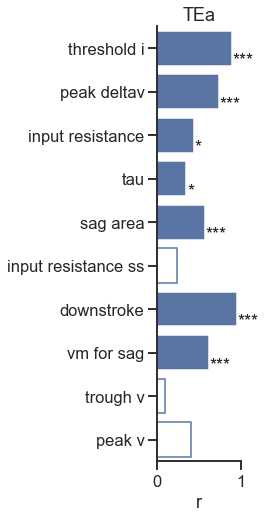

In [41]:
df = tea_df.loc[tea_df.patch_date.map(lambda x: x.split('-')[1]).astype(int) > 7]
combined_tea = pd.concat([
    df.loc[lambda df: df['Norm_Marker_Sum.0.4']=='TRUE'],
    data.loc[ lambda df: df['cortical_area']=='TEa'],
  human_df.loc[ lambda df: df['layer_lims']=='1'],
                         ],
                    sort=False)


results_tea = utils.run_twosamp(combined_tea, features, 'species')
utils.plot_feature_effect_sizes(results_tea.loc[top_feat], ylabels=labels, pval=pval,
                                val=metric, sort=False)
plt.title('TEa')
plt.xlim(0, 1)
plt.xlabel('r')

Text(0.5, 1.0, 'AIBS TEa comparison')

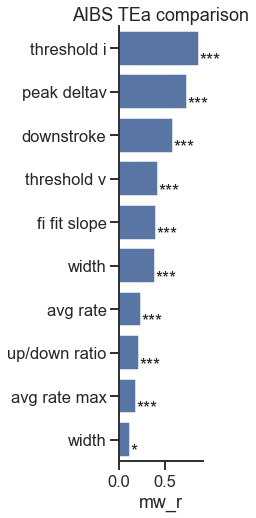

In [50]:
combined_tea = pd.concat([data.loc[ lambda df: df['cortical_area']=='TEa'],
                      human_df.loc[ lambda df: df['layer_lims']=='1']],
                    sort=False)
metric='mw_r'
pval='pval_mw_fdr'
results_tea = utils.run_twosamp(combined_tea, features, 'species').sort_values(metric, ascending=False)
top_feat = select_distinct(results_tea.index, corr, threshold=0.8)
utils.plot_feature_effect_sizes(results.loc[top_feat], ylabels=labels, pval=pval, val=metric)
plt.title('AIBS TEa comparison')

## All dataset boxplots

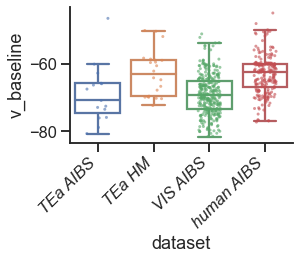

In [46]:
combined_all = pd.concat([
    data.loc[ lambda df: df['cortical_area']=='VIS'].assign(dataset="VIS AIBS"),
    tea_df.assign(collaborator="Huib", dataset="TEa HM"),
    data.loc[ lambda df: df['cortical_area']=='TEa'].assign(dataset="TEa AIBS"),
  human_df.loc[ lambda df: df['layer_lims']=='1'].assign(dataset="human AIBS"),
                         ],
                    sort=False)
plot.box_strip(data=combined_all, x='dataset', y='v_baseline')

(0.0, 750.0)

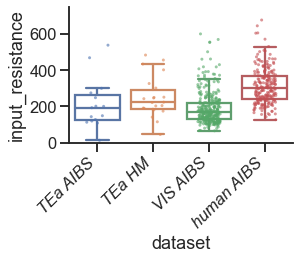

In [47]:
plot.box_strip(data=combined_all, x='dataset', y='input_resistance')
plt.ylim(0,750)

(0.0, 750.0)

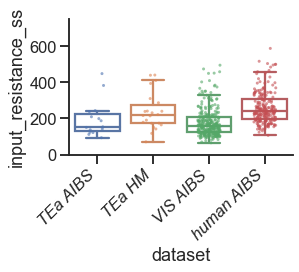

In [48]:
plot.box_strip(data=combined_all, x='dataset', y='input_resistance_ss')
plt.ylim(0,750)

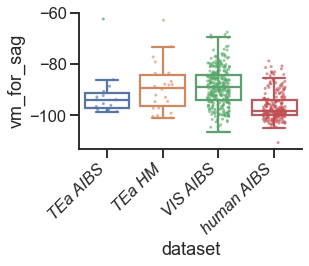

In [49]:
plot.box_strip(data=combined_all, x='dataset', y='vm_for_sag')